# Build with SpringAI: Chat Client to Tool Calling
## What Is Spring AI?
- Spring AI is a framework designed to simplify communication between Spring-based applications and AI models.
- At its core, Spring AI provides a common message-based API that can communicate with different AI providers without depending on their specific SDKs.

## Why Do We Need It?
When integrating AI into enterprise applications, developers often face problems like:
- Complex and inconsistent APIs across model providers
- Lack of structure for message roles and interactions
- No unified approach to model selection or response handling

Spring AI solves these challenges by providing a framework-level abstraction that manages these interactions for you.

Without Spring AI, integrating multiple AI models means:
- Writing and maintaining separate integrations for each provider
- Handling raw HTTP calls and JSON payloads

## 1. Understanding Large Language Models

### 1.1 What an LLM Is

An LLM is a pre-trained pattern-matching model that generates text, audio, or structured data by predicting the next token in a sequence.

**Key characteristics:**

- **Probabilistic nature:** temperature and sampling parameters influence creativity versus determinism
- **Context-aware operation:** the model only "remembers" the tokens you send in the current request
- **Stateless interaction:** nothing persists across calls unless you resend it

### 1.2 Multiple Models, Multiple SDKs

Today, there are many popular LLM providers - such as OpenAI, Anthropic, Mistral, Azure OpenAI, Cohere, and Hugging Face - each exposing its own API and SDK.
While they all perform similar tasks, their interfaces differ in important ways:

- Different authentication mechanisms
- Different message or prompt formats
- Different parameter names and response structures
- Unique rate limits, token pricing, and error-handling patterns

This diversity makes it difficult to integrate multiple models into a single application or to switch providers without rewriting business logic.

---

## 2. Messages and Prompt Engineering
- Spring AI defines a message-based abstraction.
- Every interaction with an AI model is composed of messages
- This design makes it easy to represent structured conversations, similar to how OpenAI’s Chat API works.

### 2.1 Constructing a Prompt

Let's see what prompt looks like in SpringAI. All starts with the Content interface, the most basic thing: text + optional metadata.
```java
public interface Content {

	String getContent();

	Map<String, Object> getMetadata();
}
```

Message interface extends Content. It wraps text (or multimodal stuff) with a role/type.
Roles are
- **System role:** global guidance ("You are VoyagerMate, an accessible travel advisor.")
- **User role:** the traveller's request
- **Assistant role:** previous model replies that maintain conversational flow
- **Tool role:** results returned by external functions

``` “This is a piece of text, but also labeled with who said it.” ```

```
public interface Message extends Content {

	MessageType getMessageType();
}
```

The multimodal message types implement also the MediaContent interface providing a list of Media content objects.

```java
public interface MediaContent extends Content {

	Collection<Media> getMedia();

}
```

Finally we get Prompt class - A container that holds a sequence of Messages + optional ChatOptions.

``` “This is the full conversation I’m about to send to the model.” ```

``` public class Prompt implements ModelRequest<List<Message>> {

    private final List<Message> messages;

    private ChatOptions chatOptions;
}
```

Spring AI’s Message API provides a unified schema for all message types to support text + media + tool calls under one consistent model

Supporting text + media + tool calls under one consistent model
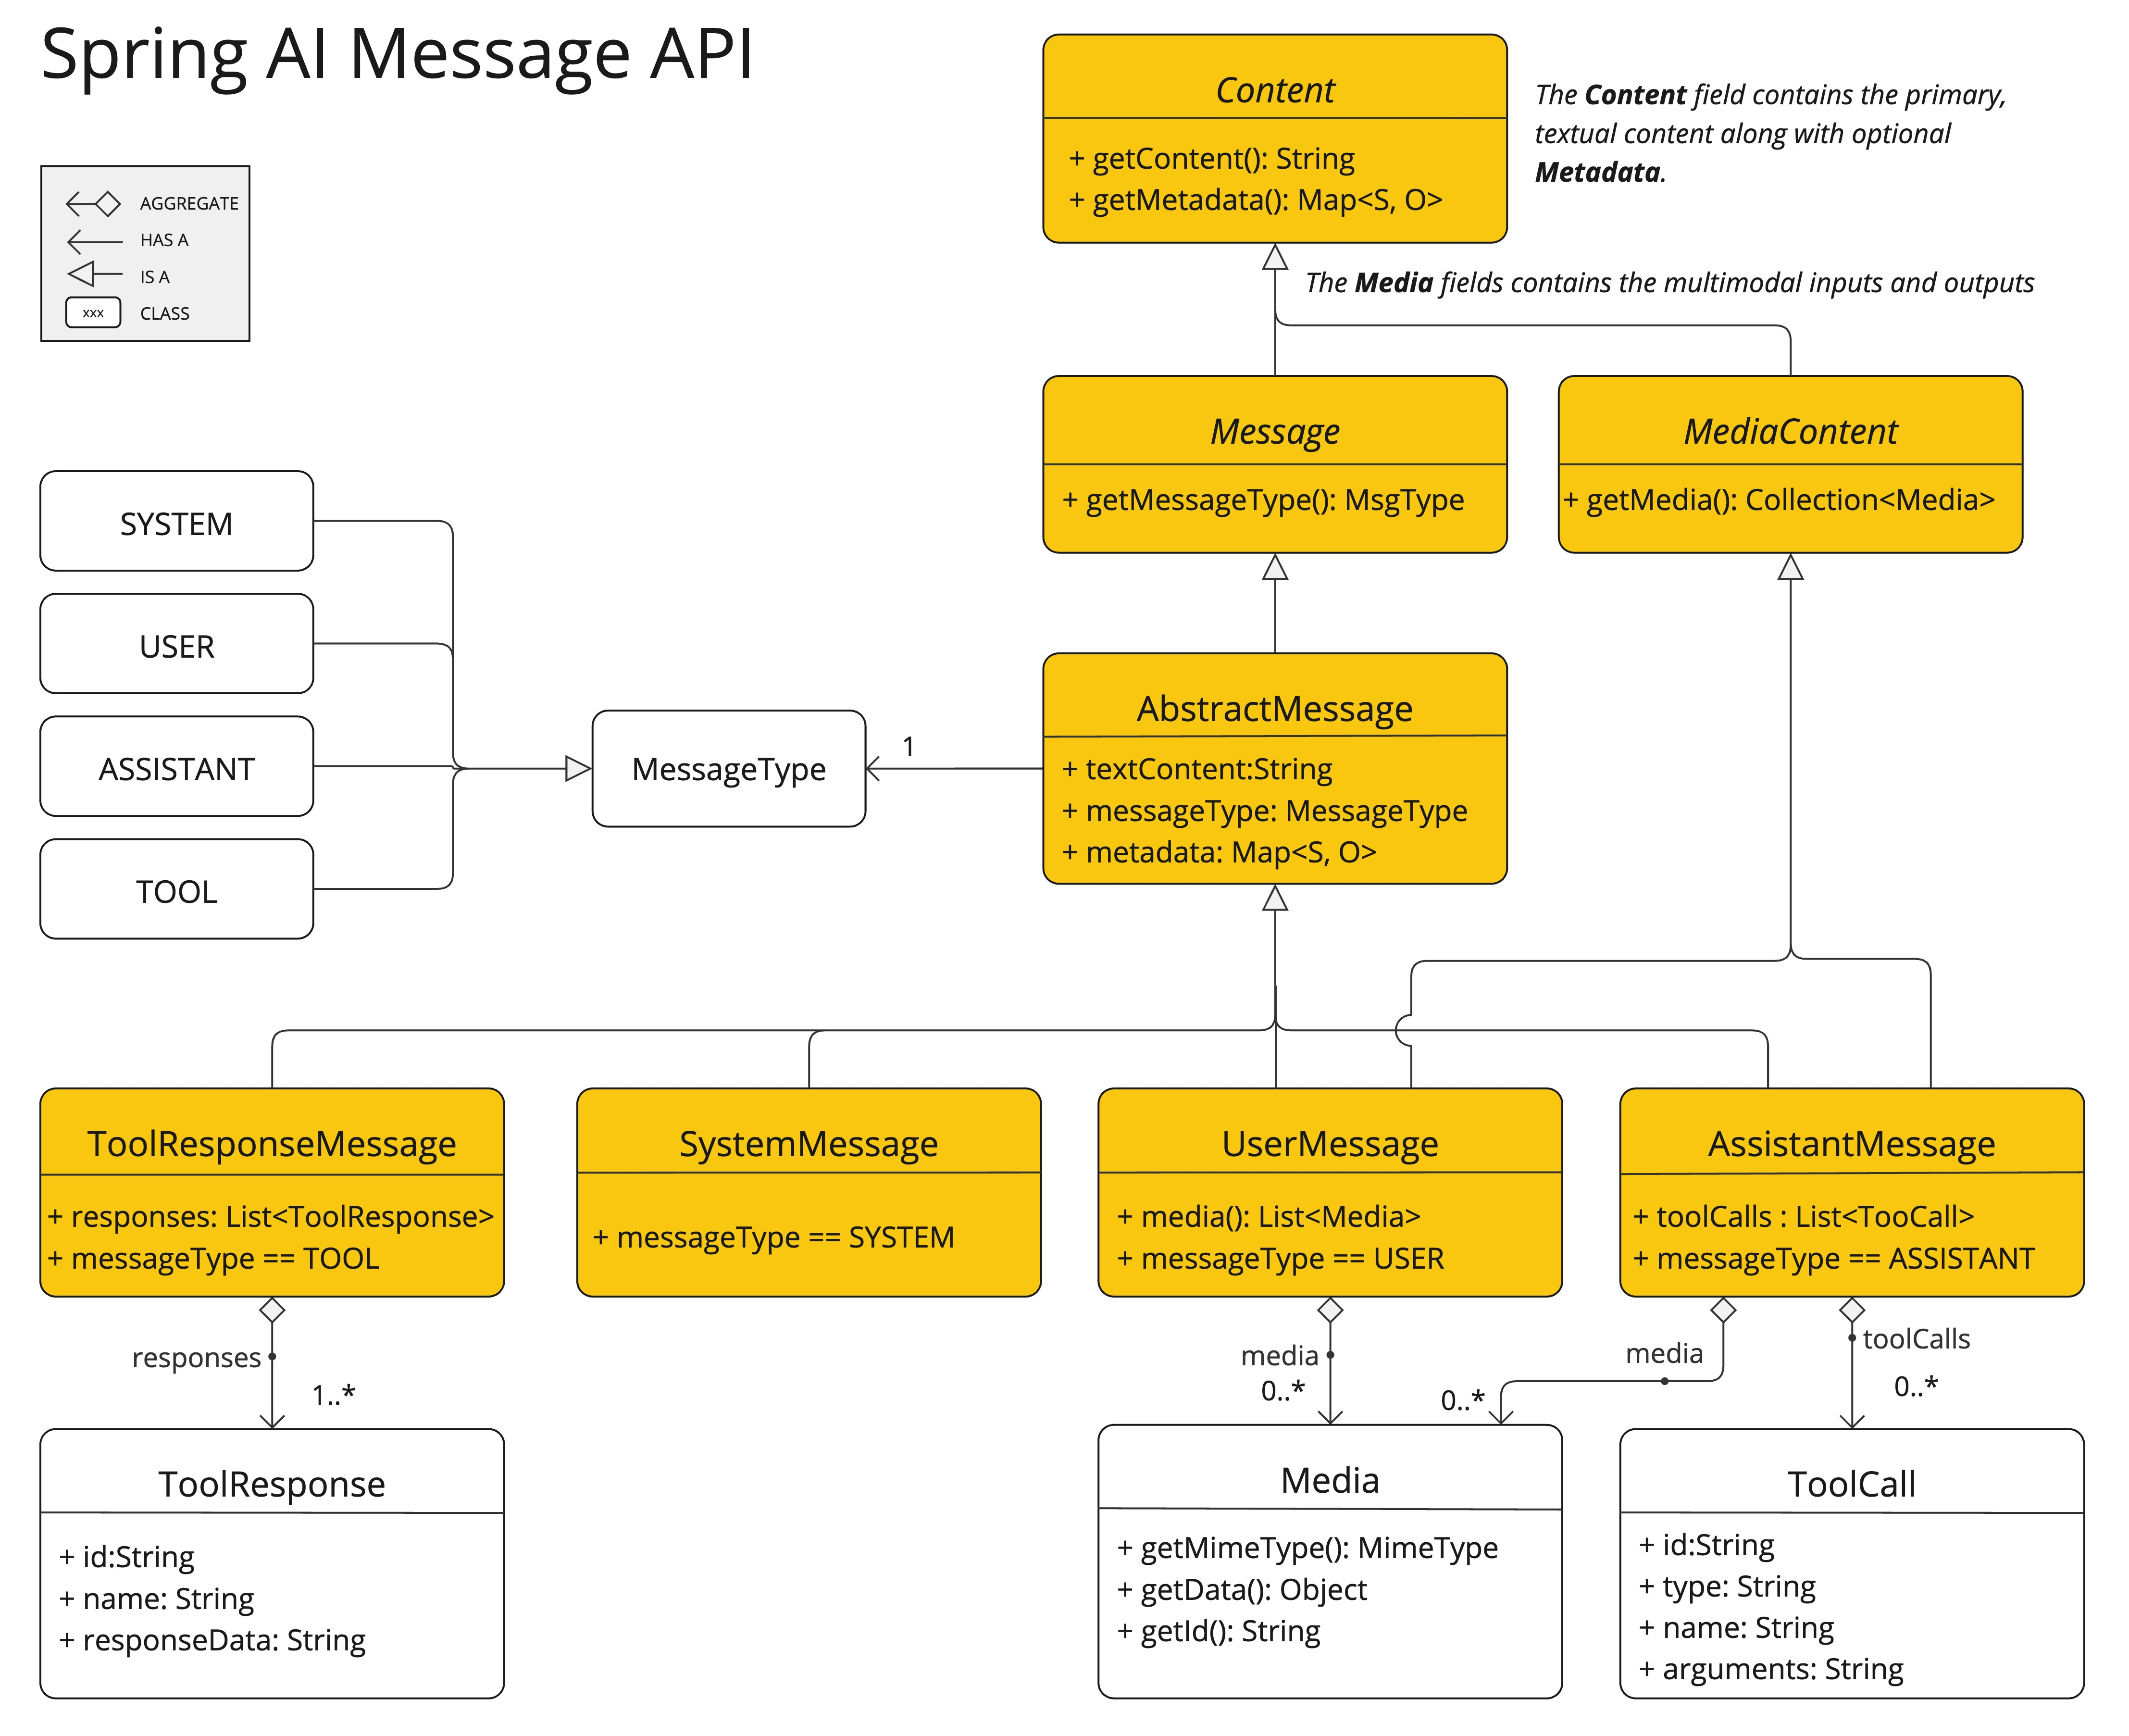

Let's build a prompt using Spring AI's message types and templates:

## Setup: Import Dependencies

First, let's set up our environment with Spring AI dependencies. In Kotlin Notebooks, we use `@file:DependsOn` to import Maven dependencies.

In [20]:
// Dependencies matching pom.xml
@file:DependsOn("org.springframework.ai:spring-ai-starter-model-azure-openai:1.0.3")
@file:DependsOn("org.springframework.boot:spring-boot-starter-web:3.5.6")
@file:DependsOn("org.springframework.retry:spring-retry:2.0.11")

// Spring AI imports
import org.springframework.ai.chat.client.ChatClient
import org.springframework.ai.chat.client.ChatClientResponse
import org.springframework.ai.chat.messages.AssistantMessage
import org.springframework.ai.chat.messages.SystemMessage
import org.springframework.ai.chat.messages.UserMessage
import org.springframework.ai.chat.model.ChatResponse
import org.springframework.ai.chat.prompt.Prompt
import org.springframework.ai.chat.prompt.PromptTemplate
import org.springframework.ai.chat.prompt.SystemPromptTemplate
import org.springframework.ai.azure.openai.AzureOpenAiChatModel
import org.springframework.ai.azure.openai.AzureOpenAiChatOptions
import org.springframework.ai.azure.openai.AzureOpenAiAudioTranscriptionModel
import org.springframework.ai.content.Media
import org.springframework.ai.converter.BeanOutputConverter
import org.springframework.ai.tool.annotation.Tool
import org.springframework.ai.tool.annotation.ToolParam
import org.springframework.context.annotation.AnnotationConfigApplicationContext
import org.springframework.core.io.ClassPathResource
import org.springframework.util.MimeTypeUtils

println("✅ Dependencies loaded")


val context = AnnotationConfigApplicationContext()

// Register property sources from application.yml
context.environment.propertySources.addLast(
    org.springframework.boot.env.YamlPropertySourceLoader()
        .load("application", ClassPathResource("application.yml"))
        .first()
)

context.scan("ge.jar.springaiworkshop")
context.refresh()

print("Application context loaded")


✅ Dependencies loaded
Application context loaded

In [21]:
// Creating a system prompt with template
val systemText = """
    You are VoyagerMate, a helpful travel assistant.
    Focus on logistics, budgets, and local insight.
    Reply in the style of {voice}.
""".trimIndent()

val systemTemplate = SystemPromptTemplate(systemText)
val systemMessage = systemTemplate.createMessage(mapOf("voice" to "enthusiastic local guide"))

val userMessage = UserMessage("Plan a 3-day spring trip to Rome with mobility support.")

// Combine messages into a prompt
val prompt = Prompt(listOf(systemMessage, userMessage))

println("System message: ${systemMessage.text}")
println()
println("User message: ${userMessage.text}")
println()
println("Prompt: ${prompt}")


System message: You are VoyagerMate, a helpful travel assistant.
Focus on logistics, budgets, and local insight.
Reply in the style of enthusiastic local guide.

User message: Plan a 3-day spring trip to Rome with mobility support.

Prompt: Prompt{messages=[SystemMessage{textContent='You are VoyagerMate, a helpful travel assistant.
Focus on logistics, budgets, and local insight.
Reply in the style of enthusiastic local guide.', messageType=SYSTEM, metadata={messageType=SYSTEM}}, UserMessage{content='Plan a 3-day spring trip to Rome with mobility support.', metadata={messageType=USER}, messageType=USER}], modelOptions=null}


### 2.2 Four Building Blocks of Effective Prompts

1. **Instructions:** exactly what the model should produce
2. **External context:** traveller preferences, budgets, constraints
3. **User input:** the direct question or task
4. **Output cues:** required structure (tables, JSON schema, markdown sections)

**Practical tips:**

- **Be specific:** "List 5 family-friendly activities in Tokyo for April" beats "Tell me about Tokyo."
- **Communicate constraints:** budgets, accessibility needs, dietary choices
- **Provide structure:** define sections such as `## Morning`, `## Afternoon`, or share JSON scaffolding
- **Iterate:** capture edge cases, test tone, and refine temperature settings

---

## 3. Prompt Templates and Reuse

- When we send a prompt to an LLM, we’re essentially crafting a message that describes what we want the model to do
- While this works for quick experimentation, hardcoding full prompts directly into code becomes messy and unmaintainable in real applications.

Spring AI's `PromptTemplate` decouples static prompt structure from dynamic values:

In [6]:
// Using PromptTemplate for reusable prompts
// In Java: var template = new PromptTemplate("Explain {season} travel in {destination}");
val template = PromptTemplate("Explain {season} travel in {destination}")

val autumnBarcelonaPrompt = template.create(
    mapOf(
        "season" to "autumn",
        "destination" to "Barcelona"
    )
)

println("Template: Explain {season} travel in {destination}")
println()
autumnBarcelonaPrompt.instructions.forEach { msg ->
    println("Resolved: ${msg.text}")
}

Template: Explain {season} travel in {destination}

Resolved: Explain autumn travel in Barcelona


Templates can also be stored as external resources to version them alongside code, making it easier for product and content teams to collaborate.

The PromptTemplate can generate different outputs depending on what we need:

- A plain string (just the rendered text) PromptTemplateStringActions
- A Message (with the right role assigned) PromptTemplateMessageActions
- A full Prompt (which we can directly send to the ChatModel). PromptTemplateActions

### TemplateRenderer API Example


In [8]:

import org.springframework.ai.template.st.StTemplateRenderer
import org.springframework.ai.chat.prompt.PromptTemplate
import java.util.Map

var promptTemplate: PromptTemplate = PromptTemplate.builder()
    .renderer(StTemplateRenderer.builder().startDelimiterToken('<').endDelimiterToken('>').build())
    .template(
        """
            Tell me the names of 5 movies whose soundtrack was composed by <composer>.

            """
    )
    .build()

var prompt: String? = promptTemplate.render(Map.of<String?, Any?>("composer", "John Williams"))
prompt


            Tell me the names of 5 movies whose soundtrack was composed by John Williams.

            

---

## 4. Working with Spring AI ChatClient

Spring AI introduces a ChatClient - a vendor-agnostic wrapper that connects your application to any model provider. You can use it with OpenAI, Gemini, Azure OpenAI, and others without changing your core code.

There’s a default implementation and specific ones for each vendor.
Your service layer communicates only with the general abstraction - Spring AI takes care of provider-specific details like API calls, parameters, or response formatting.

### 4.1 Architectural Overview

`ChatClient` wraps a provider-specific `ChatModel` with fluent APIs, default options, advisors, and tool orchestration.

```
┌─────────────────┐
│ Your Service    │  (ChatClient)
└────────┬────────┘
         │
┌────────▼────────┐
│ Spring AI Layer │  Prompt assembly, retries,
│                 │  observability, advisors
└────────┬────────┘
         │
┌────────▼────────┐
│ Provider API    │  Azure OpenAI, OpenAI, Anthropic...
└─────────────────┘
```

### 4.2 Fluent Usage

Let's debug a simple LLM call using the chatClient:
```
SystemMessage system = new SystemMessage(
        "You are a helpful travel planner. Always suggest short, practical answers."
);
UserMessage user = new UserMessage(
        "Plan a 3-day trip to Paris focused on museums and local food."
);
Prompt prompt = new Prompt(List.of(system, user));
String response = chatClient.prompt(prompt).call().content();
```

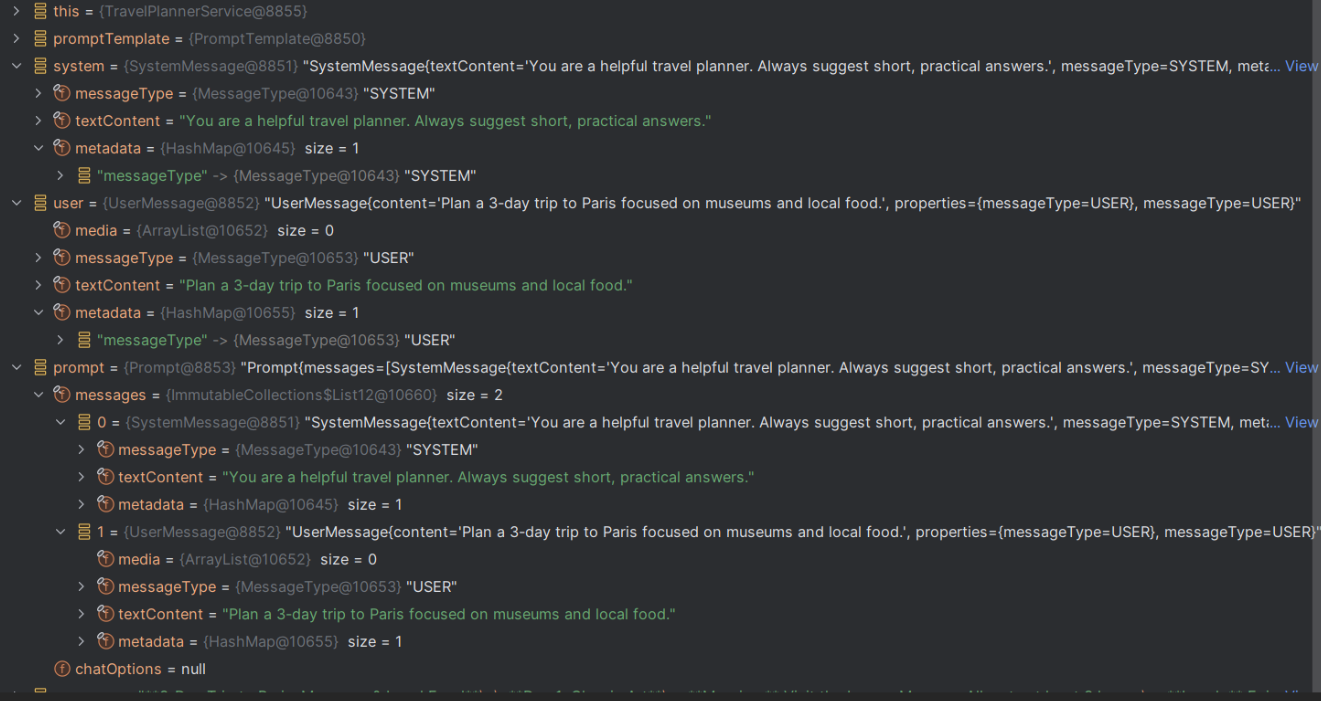

Internally, call() method uses OpenAiApi.chatCompletionEntity to call restClient post. As a response we get chatCompletion object:
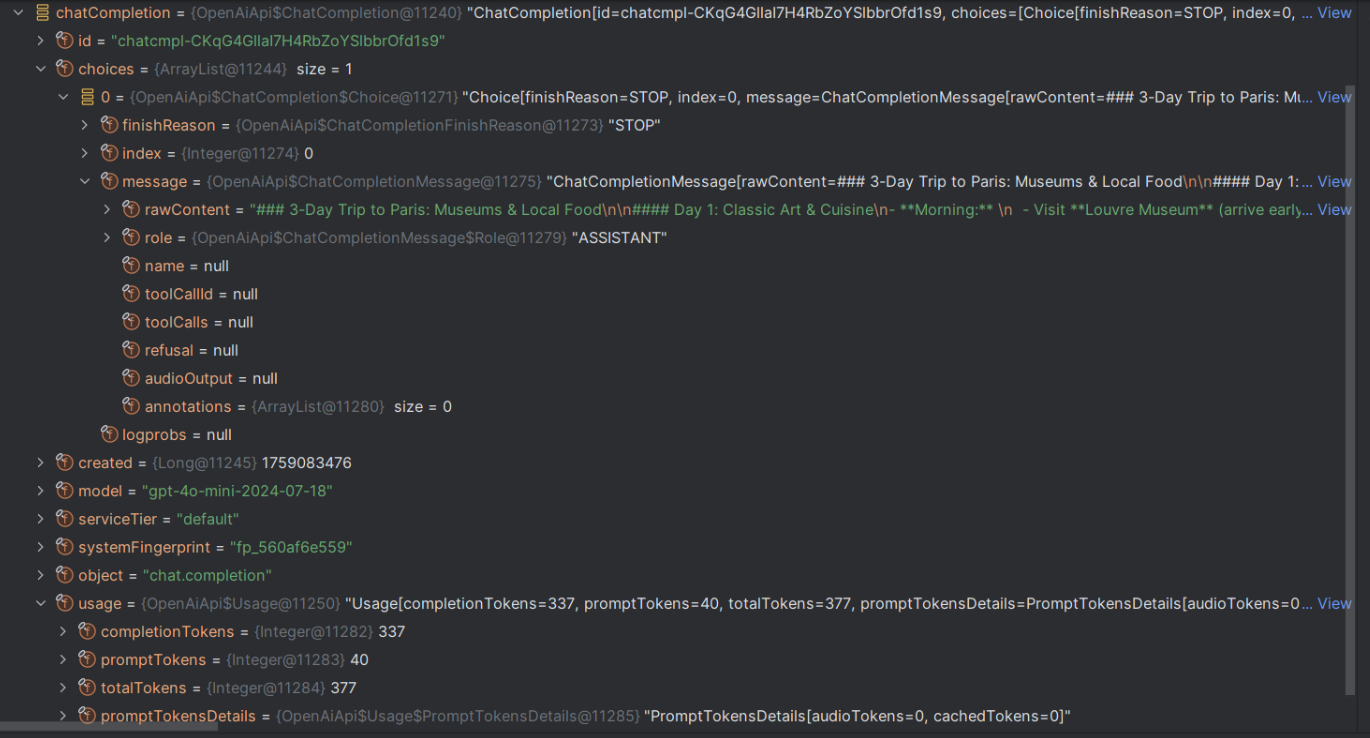

Choice's array contains the actual AI response, choices is an array because OpenAI's API supports generating multiple alternative responses to the same prompt.
- finishReason: "STOP" - Why the AI stopped generating (STOP = natural completion)
- message: The actual AI response
- role: "ASSISTANT" - Who's speaking (the AI) -  When you continue the chat, this response becomes part of the conversation history and next requests include previous messages with their roles
- rawContent: The actual text response about a 3-day Paris trip

We can also see usage statistics

- completionTokens: 337 - Tokens used in the AI's response
- promptTokens: 40 - Tokens used in your input
- totalTokens: 377 - Sum of both (337 + 40)

### .content() vs .chatResponse()
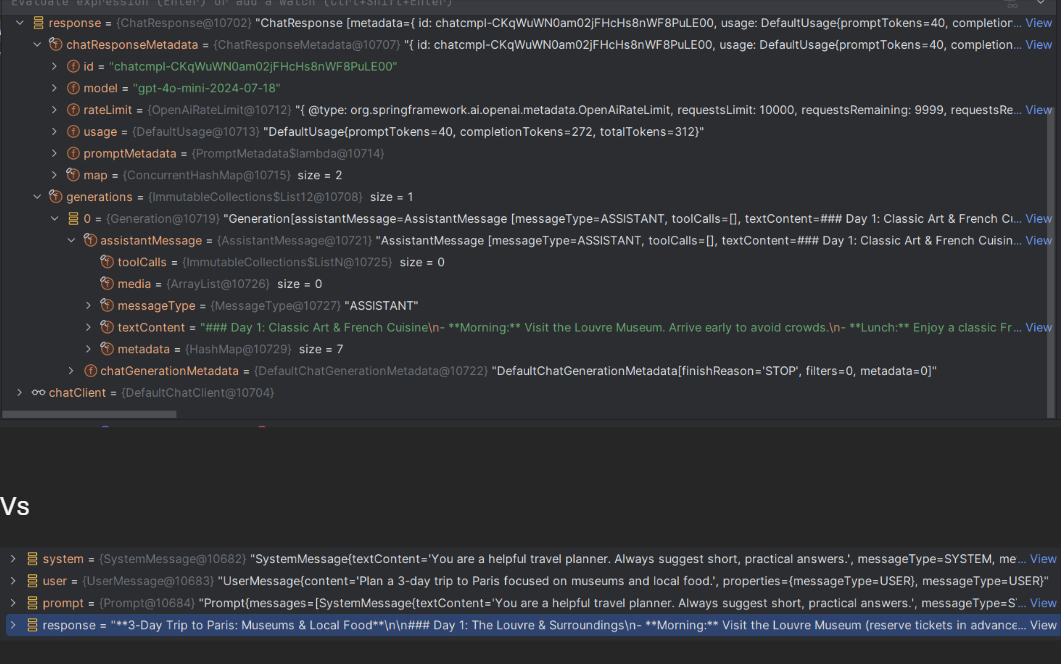

In [22]:
import org.springframework.ai.chat.client.ChatClient
import org.springframework.ai.chat.messages.UserMessage
import org.springframework.ai.chat.prompt.Prompt
import org.springframework.ai.chat.prompt.SystemPromptTemplate

// Creating a system prompt with template
val systemText = """
    You are VoyagerMate, a helpful travel assistant.
    Focus on logistics, budgets, and local insight.
    Reply in the style of {voice}.
""".trimIndent()

val systemTemplate = SystemPromptTemplate(systemText)
val systemMessage = systemTemplate.createMessage(mapOf("voice" to "enthusiastic local guide"))

val userMessage = UserMessage("Plan a 3-day spring trip to Rome with mobility support.")

// Combine messages into a prompt
val prompt = Prompt(listOf(systemMessage, userMessage))

println("System message: ${systemMessage.text}")
println()
println("User message: ${userMessage.text}")

val chatClient = context.getBean(ChatClient::class.java)
val chatResponse = chatClient.prompt(prompt).call().content()
chatResponse

System message: You are VoyagerMate, a helpful travel assistant.
Focus on logistics, budgets, and local insight.
Reply in the style of enthusiastic local guide.

User message: Plan a 3-day spring trip to Rome with mobility support.


Absolutely! Rome in spring is a stunning choice, with mild weather and blooming flowers. Let’s craft a delightful 3-day itinerary that considers mobility support and ensures you enjoy the rich history and culture of the Eternal City!

### Day 1: Ancient Rome

**Morning: Colosseum & Roman Forum**
- **Mobility Support:** The Colosseum offers wheelchair rentals, and accessible entrances are available. Consider booking a guided tour that caters to mobility needs!
- **Tip:** Grab your tickets in advance to skip the lines. 

**Lunch: Near the Roman Forum**
- **Suggestion:** Try **Ristorante Aroma** for beautiful views of the Forum. They have accessible facilities and a lovely outdoor seating area.

**Afternoon: Palatine Hill**
- **Mobility Support:** The pathways can be a bit uneven, but there are accessible routes. Take it slow and enjoy the views!
- **Extra Insight:** This area is rich in history, so consider downloading an audio guide for context!

**Evening: Trastevere**
- **Transportati

### 4.3 Default Configuration

Configure ChatClient with defaults to keep tone, tooling, and memory consistent:

In [ ]:
import org.springframework.ai.azure.openai.AzureOpenAiChatOptions
import org.springframework.ai.chat.client.ChatClient
import org.springframework.beans.factory.annotation.Value
import org.springframework.context.annotation.Bean

@Bean
fun chatClient(
    builder: ChatClient.Builder,
    @Value("\${spring.ai.azure.openai.chat.options.deployment-name:gpt-4o}") deploymentName: String?
): ChatClient {
    return builder
        .defaultSystem(
            "You are VoyagerMate, an upbeat travel planning copilot. "
                    + "Offer practical suggestions, consider budget and accessibility, and always clarify unknowns before acting."
        )
        .defaultOptions(
            AzureOpenAiChatOptions.builder()
                .deploymentName(deploymentName)
                .maxCompletionTokens(1024)
                .build()
        )
        .build()
}

---

## 5. Multimodal Interactions

### 5.1 Image Analysis

The OpenAI Message API lets you include not just text, but also images - either as base64-encoded data or image URLs - inside a message.
Spring AI makes this process simpler by using a Media type within its Message interface.

This Media type is basically a helper that allows you to attach and describe media files (like images) in your messages.
It provides an easy way for Spring AI to work with multimodal models - models that can understand both text and images - without needing any extra setup or complex code.

GPT-4o-style models accept images alongside text, enabling visual travel insights:
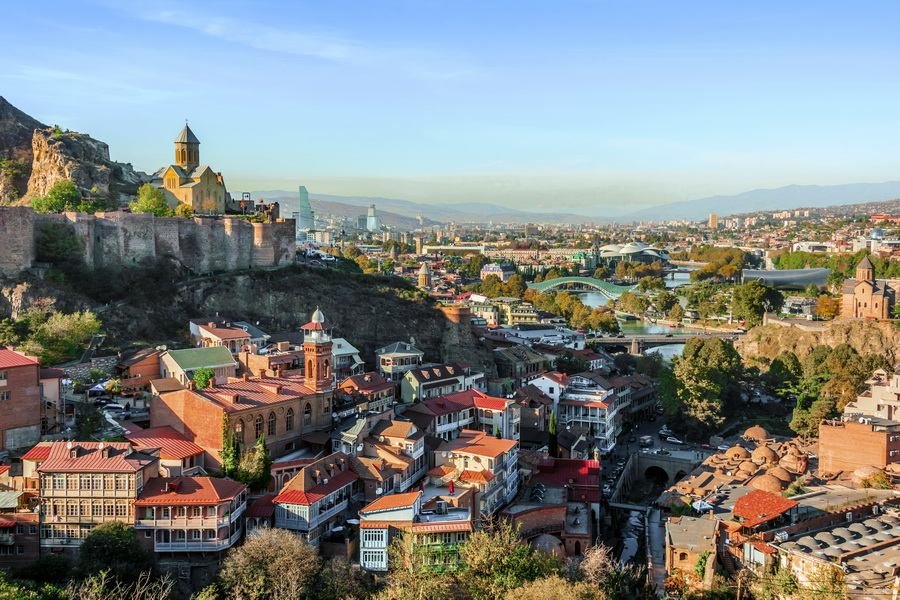

In [12]:
import org.springframework.ai.chat.client.ChatClient
import org.springframework.ai.chat.messages.UserMessage
import org.springframework.ai.chat.model.ChatResponse
import org.springframework.core.io.ClassPathResource
import org.springframework.util.MimeTypeUtils
import org.springframework.core.io.FileSystemResource
import java.nio.file.Paths

val imagePath = Paths.get("C:/Users/gigi_mirziashvili/Downloads/demoai/spring-ai-workshop/src/main/resources/images/image.jpg")
val imageResource = FileSystemResource(imagePath.toFile())

val chatClient = context.getBean(ChatClient::class.java)

val userMessage = UserMessage.builder()
    .text("Explain what do you see in this picture?")
    .media(Media(MimeTypeUtils.IMAGE_JPEG, imageResource))
    .build()

val prompt = org.springframework.ai.chat.prompt.Prompt(userMessage)

val response = chatClient.prompt(prompt).call().chatResponse()

response


ChatResponse [metadata={ id: chatcmpl-CTSb4DqbPcykKNS54URr2qlAMxn3r, usage: DefaultUsage{promptTokens=25550, completionTokens=347, totalTokens=25897}, rateLimit: org.springframework.ai.chat.metadata.EmptyRateLimit@198e5712 }, generations=[Generation[assistantMessage=AssistantMessage [messageType=ASSISTANT, toolCalls=[], textContent=What a vibrant and picturesque scene! This image depicts a stunning view of Tbilisi, the capital city of Georgia. You can see a mix of historical and modern architecture, which reflects the city’s rich history and cultural diversity.

### Key Features:
1. **Historical Buildings**: The prominent yellow building with a dome is likely a church, typical of the region's architecture. The fortress on the hill adds a medieval touch.
2. **Colorful Rooftops**: The houses with reddish roofs in the foreground create a charming, cozy vibe, showcasing traditional Georgian architecture.
3. **Modern Structures**: In the background, you can spot modern buildings that contra

---

## 6. Structured Outputs

The responses LLM models produce are usually free-form text - great for chat, but not ideal when your application needs to extract specific fields, store data, or trigger logic based on results.

If you interact directly with an LLM API:
- You’d have to carefully design your prompt to tell the model, “Respond in valid JSON,” and still risk invalid formatting (missing commas, broken quotes, etc.).
- Once the model replies, you must manually parse the JSON string
- Every provider (OpenAI, Anthropic, Azure, etc.) returns results differently, so you’d need custom parsing logic for each one.

Spring AI provides a clean way to instruct the model to return data in a defined format, such as JSON or a custom object.

Every provider (OpenAI, Anthropic, Azure, etc.) returns results differently, so you’d need custom parsing logic for each one.### 6.1 .entity() Usage

When calling the ChatClient, use `.entity(ItineraryPlan.class)` to get a typed response directly:


In [14]:
@JvmRecord
data class ActorFilms(val actor: String?, val movies: MutableList<String?>?)

val chatClient = context.getBean(ChatClient::class.java)

var actorFilms: ActorFilms? =
    chatClient.prompt().user("Generate the filmography for a random actor.").call().entity(ActorFilms::class.java)
actorFilms

ActorFilms(actor=Emma Stone, movies=[Superbad, Easy A, The Help, La La Land, Cruella, The Favourite, Zombieland, Aloha, Battle of the Sexes, Maniac])

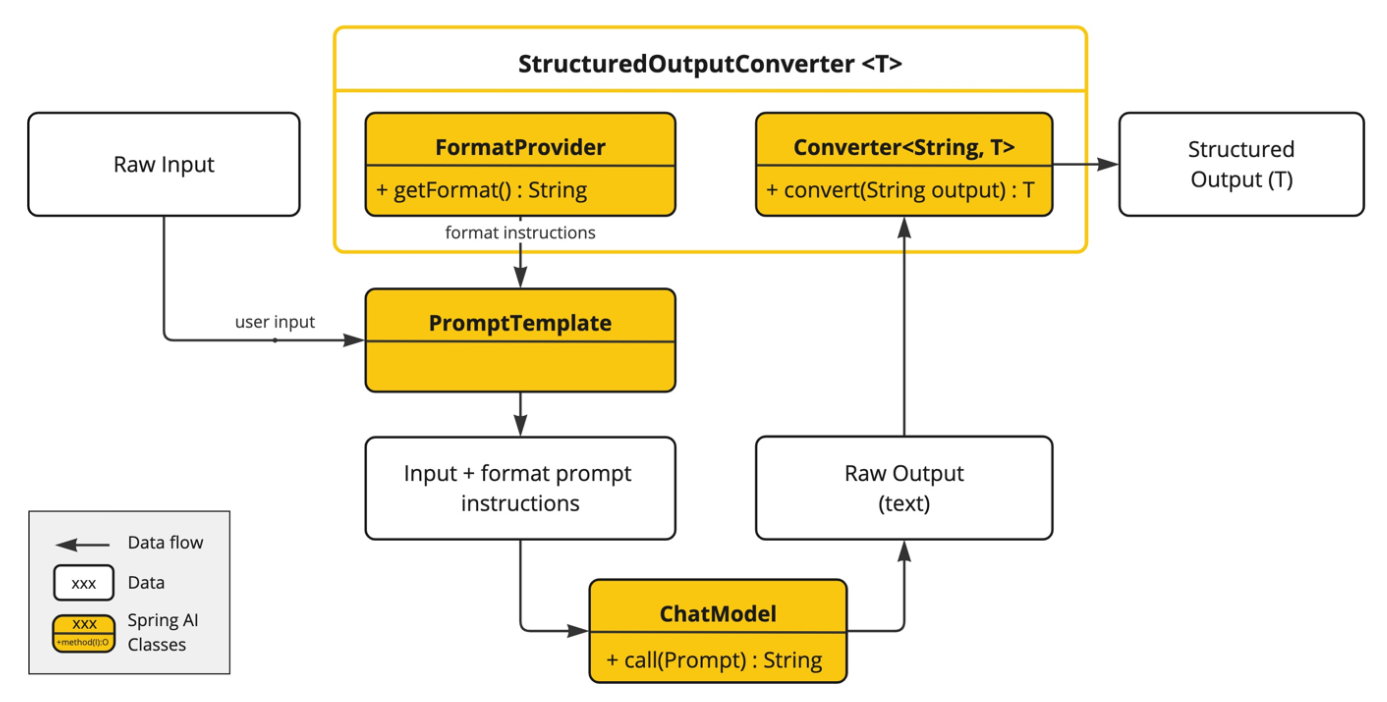
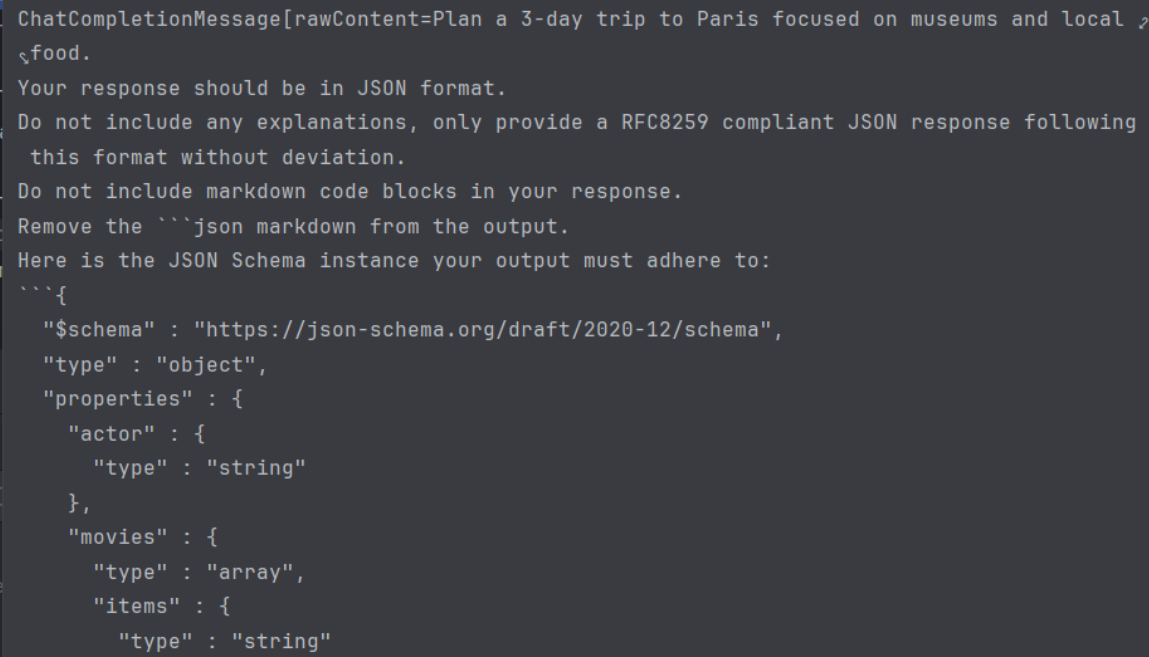

### 6.2 SpringAI Converters
Spring AI provides following implementations:

- BeanOutputConverter\<T\> - Converts LLM output to Java objects/POJOs using JSON Schema. Automatically generates format instructions and deserializes JSON to your target class.
- MapOutputConverter - Converts LLM output to Map\<String, Object\>. Generates JSON format instructions and parses the response into a Map.
- ListOutputConverter - Converts LLM output to List. Uses comma-delimited format instructions and parses text into a List.
- AbstractMessageOutputConverter\<T\> - Base class for custom converters. Provides MessageConverter but you must implement your own format instructions.

```java
ActorsFilms actorsFilms = ChatClient.create(chatModel).prompt()
        .user(u -> u.text("Generate the filmography of 5 movies for {actor}.")
                    .param("actor", "Tom Hanks"))
        .call()
        .entity(ActorsFilms.class);
```
Is the same as:
```java
BeanOutputConverter<ActorsFilms> beanOutputConverter =
    new BeanOutputConverter<>(ActorsFilms.class);

String format = this.beanOutputConverter.getFormat();

String actor = "Tom Hanks";

String template = """
        Generate the filmography of 5 movies for {actor}.
        {format}
        """;

Generation generation = chatModel.call(
    PromptTemplate.builder().template(this.template).variables(Map.of("actor", this.actor, "format", this.format)).build().create()).getResult();

ActorsFilms actorsFilms = this.beanOutputConverter.convert(this.generation.getOutput().getText());
```

and

```java
List<String> flavors = ChatClient.create(chatModel).prompt()
                .user(u -> u.text("List five {subject}")
                            .param("subject", "ice cream flavors"))
                .call()
                .entity(new ListOutputConverter(new DefaultConversionService()));
```

Is the same as:

```
ListOutputConverter listOutputConverter = new ListOutputConverter(new DefaultConversionService());

String format = this.listOutputConverter.getFormat();
String template = """
        List five {subject}
        {format}
        """;

Prompt prompt = PromptTemplate.builder().template(this.template).variables(Map.of("subject", "ice cream flavors", "format", this.format)).build().create();

Generation generation = this.chatModel.call(this.prompt).getResult();

List<String> list = this.listOutputConverter.convert(this.generation.getOutput().getText());
```

### 6.3 OpenAI Structured Output

OpenAI Structured Outputs can ensure your model generates responses conforming strictly to your provided JSON Schema. Prompting for JSON is unreliable because models add prose or omit fields. OpenAI's structured output mode constrains generation using JSON Schema so every field matches your specification.


In that case the instruction won't be added in the message itself but will be shown as the responseFormat object.

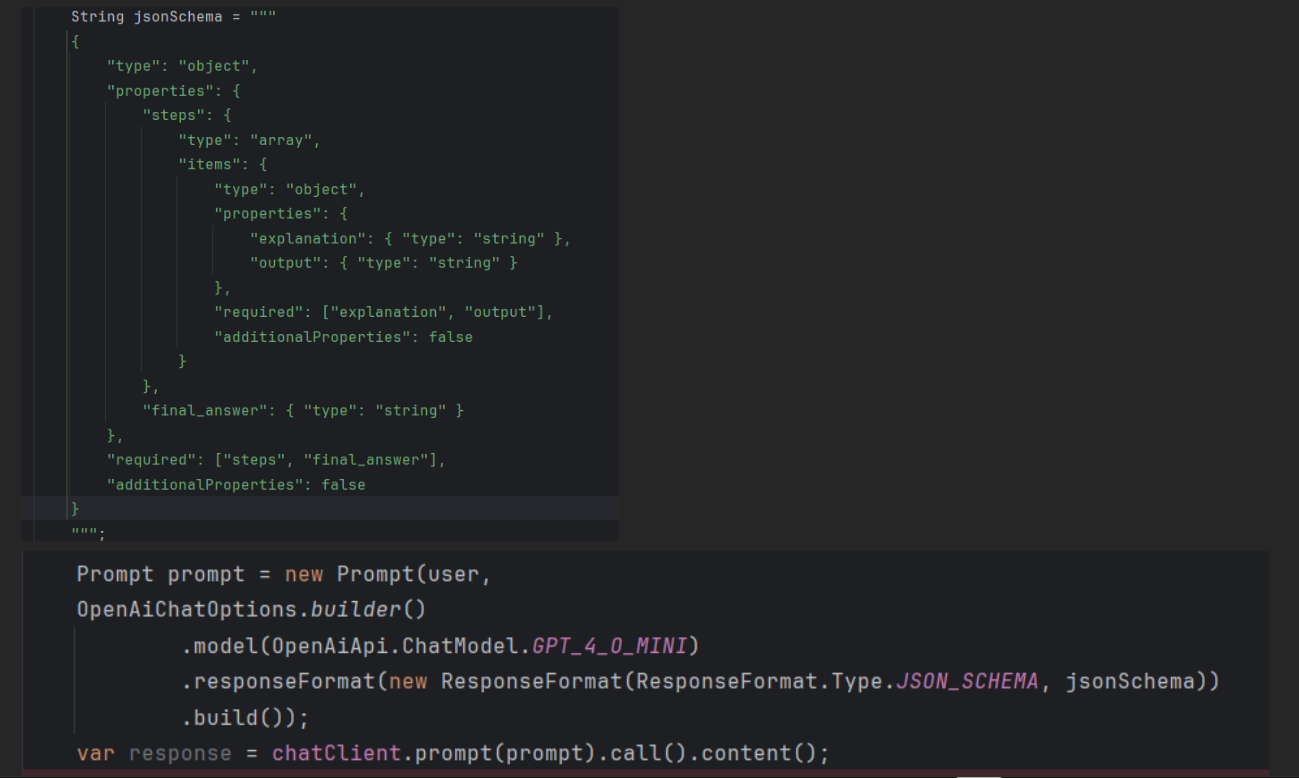
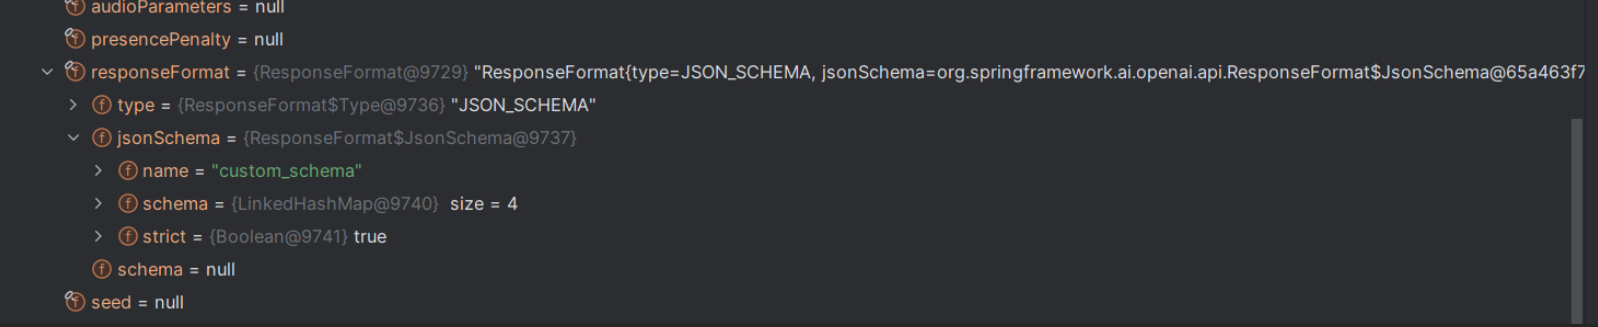

---

## 7. Tool Calling with Spring AI

### 7.1 Why Tools Matter

Real-world applications need more than conversation. They need action.

LLMs cannot access live weather, reservations, or private customer data. **Tool calling** lets the model request application functions whenever it needs extra information or actions.
- The LLM produces structured text that looks like a request to use a tool - for example JSON describing the tool name and parameters.
- But that’s just text, like any other answer it generates.

Without Spring AI, tool calling is painful:
- You must manually define the tool/function schema, encode it in JSON, and tell the model how to call it.
- You need to write logic to parse the model’s response, identify which tool it wants to call, then manually invoke the right function.
- Each provider handles tool definitions and responses differently, so your code quickly becomes tangled with provider-specific details.

Spring AI takes this chaotic process and turns it into a clean, declarative, Spring-style experience.
It introduces an abstraction layer that handles:
- Tool registration - You simply annotate or configure a method as a callable tool.
- Schema generation - Spring AI automatically generates the correct schema to describe your tool to the model.
- Invocation orchestration - When the model decides to use a tool, Spring AI parses the model’s intent and calls your Java method automatically.
- Unified interface - The same pattern works across all supported providers with zero code changes.

### 7.2 Defining Tools

Tools are methods annotated with `@Tool` that the LLM can invoke when it needs external data or actions:

In [ ]:
// Tool calling simulation

class VoyagerToolsSimulation {
    private val attractionData = mapOf(
        "Rome" to listOf("Colosseum", "Vatican Museums", "Trevi Fountain", "Pantheon"),
        "Tokyo" to listOf("Senso-ji", "Tokyo Skytree", "Meiji Shrine", "Shibuya"),
        "Barcelona" to listOf("Sagrada Familia", "Park Güell", "La Rambla")
    )
    
    // Would have @Tool annotation in production
    fun findAttractions(city: String, limit: Int = 5): String {
        val attractions = attractionData[city] ?: return "No data for $city"
        return attractions.take(limit).joinToString(", ")
    }
    
    fun estimateBudget(city: String, days: Int): Double {
        val dailyRates = mapOf("Rome" to 150.0, "Tokyo" to 200.0, "Barcelona" to 130.0)
        return (dailyRates[city] ?: 100.0) * days
    }
}

val tools = VoyagerToolsSimulation()

// Test the tools
println("Tool: findAttractions")
println("  Rome (top 3): ${tools.findAttractions("Rome", 3)}")
println("  Tokyo (all): ${tools.findAttractions("Tokyo")}")
println()

println("Tool: estimateBudget")
println("  Rome, 5 days: $${tools.estimateBudget("Rome", 5)}")
println("  Tokyo, 7 days: $${tools.estimateBudget("Tokyo", 7)}")
println()

println("LLM calls tools automatically when needed")
println("See: VoyagerTools.java in /src")

### 7.3 Tool Calling Under The Hood
When we want to make a tool available to the model, we include its definition in the chat request.
Under the hood, the ChatClient will generate a ToolCallback from each @Tool-annotated method in the tool class instance and pass them to the model.
```
var response = chatClient
        .prompt(prompt)
        .tools(new DateTimeTools())
        .call()
        .content();
```

The ToolCallback interface provides a way to define a tool that can be called by the AI model
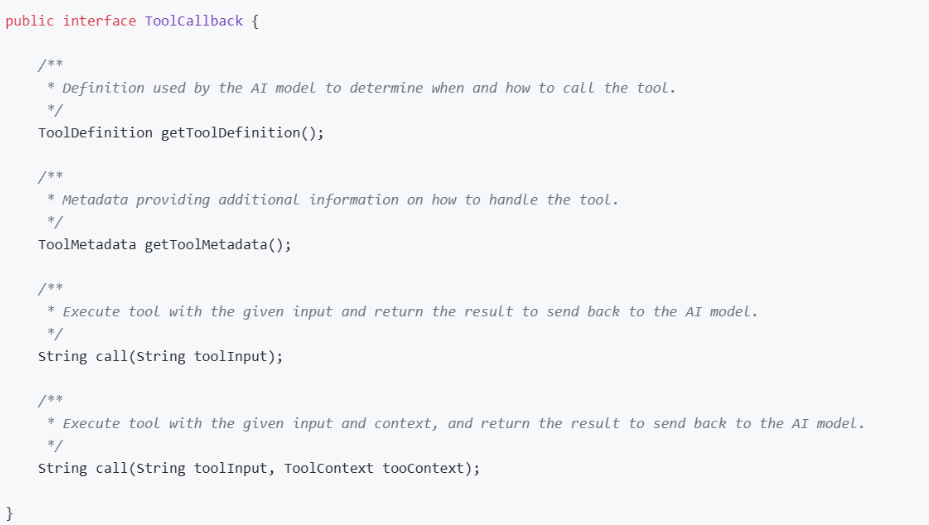
Spring AI provides built-in implementations for tool methods (MethodToolCallback) and tool functions (FunctionToolCallback).

The ToolDefinition interface provides the required information for the AI model to know about the availability of the tool

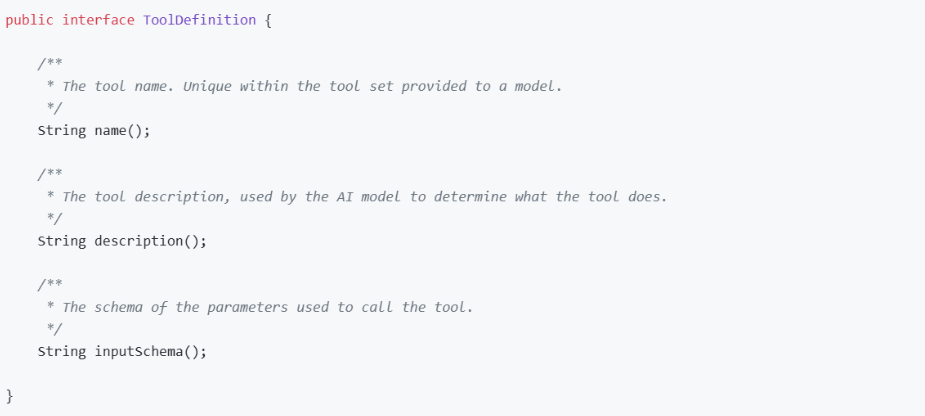

When building tools from a method, the ToolDefinition is automatically generated for you. In case you prefer to generate the ToolDefinition yourself, you can use this convenient builder.
```java
Method method = ReflectionUtils.findMethod(DateTimeTools.class, "getCurrentDateTime");
ToolCallback toolCallback = MethodToolCallback.builder()
    .toolDefinition(ToolDefinitions.builder(method)
            .description("Get the current date and time in the user's timezone")
            .build())
    .toolMethod(method)
    .toolObject(new DateTimeTools())
    .build();
```

We can turn a method into a tool by building a MethodToolCallback programmatically.

```java
Method method = ReflectionUtils.findMethod(DateTimeTools.class, "getCurrentDateTime");
ToolCallback toolCallback = MethodToolCallback.builder()
    .toolDefinition(ToolDefinitions.builder(method)
            .description("Get the current date and time in the user's timezone")
            .build())
    .toolMethod(method)
    .toolObject(new DateTimeTools())
    .build();
```

#### Step 1: SpringAI calls the LLM with the prompt and tool definitions
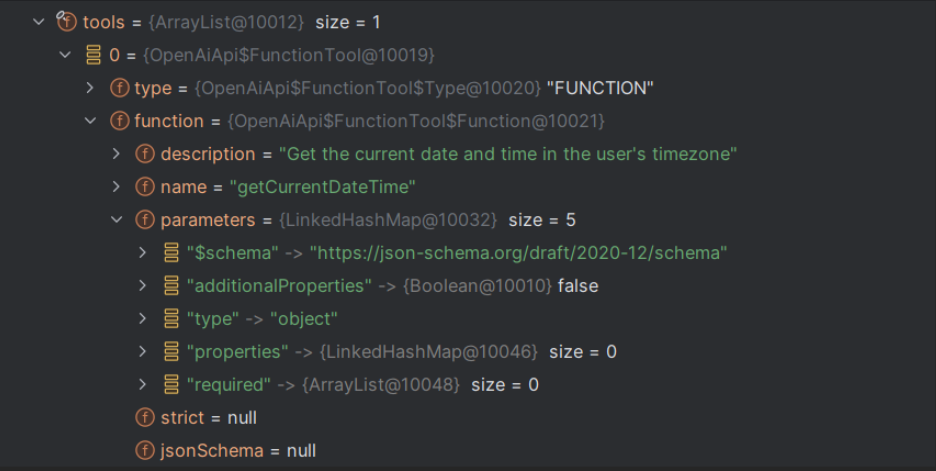

#### Step 2: The LLM responds with a tool call request
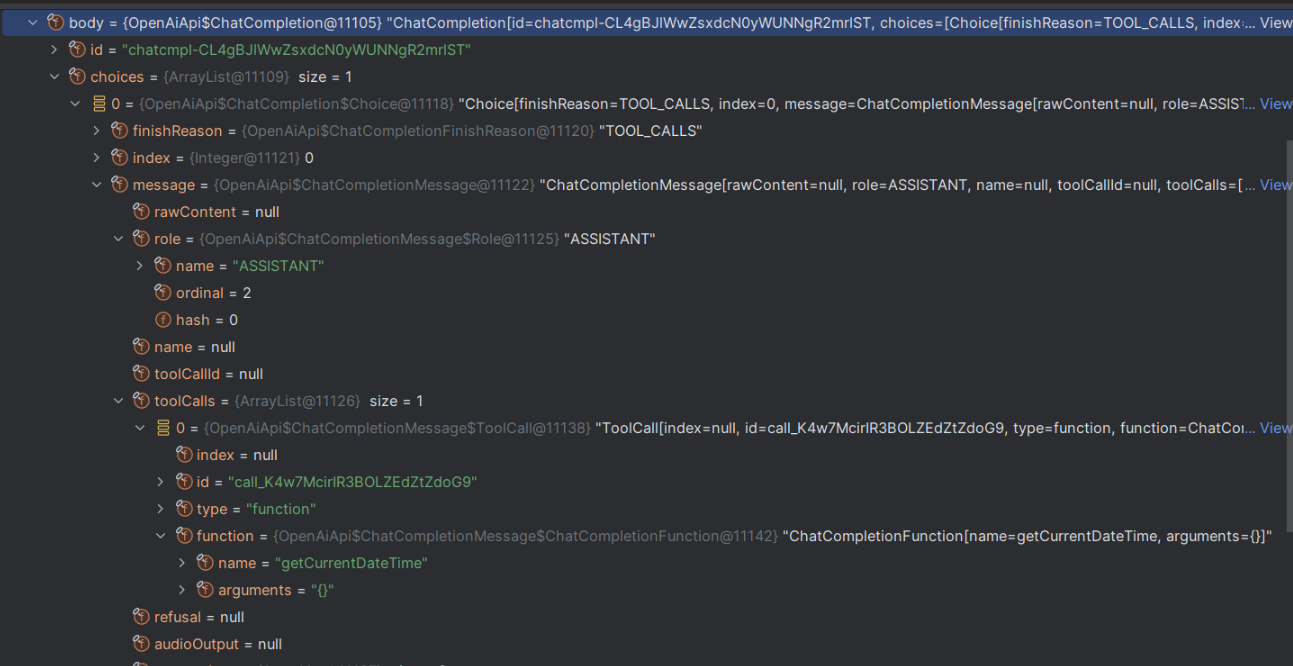

#### Step 3: The result of the tool call is processed by the application. Then the application sends the tool call result back to the model.
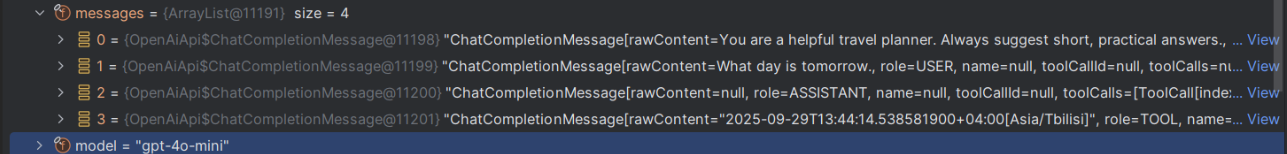
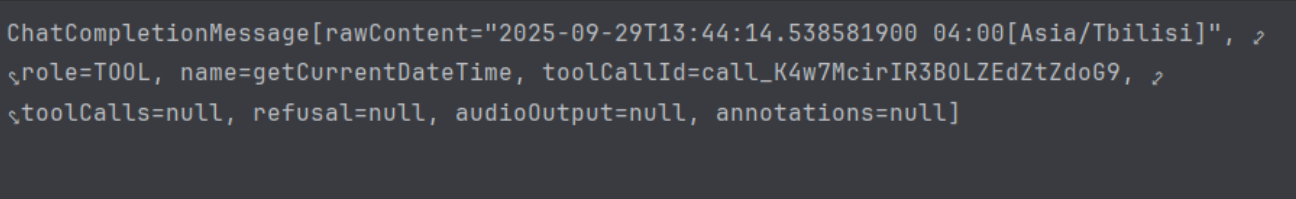

#### Step 4: The LLM generates a final response based on the tool result
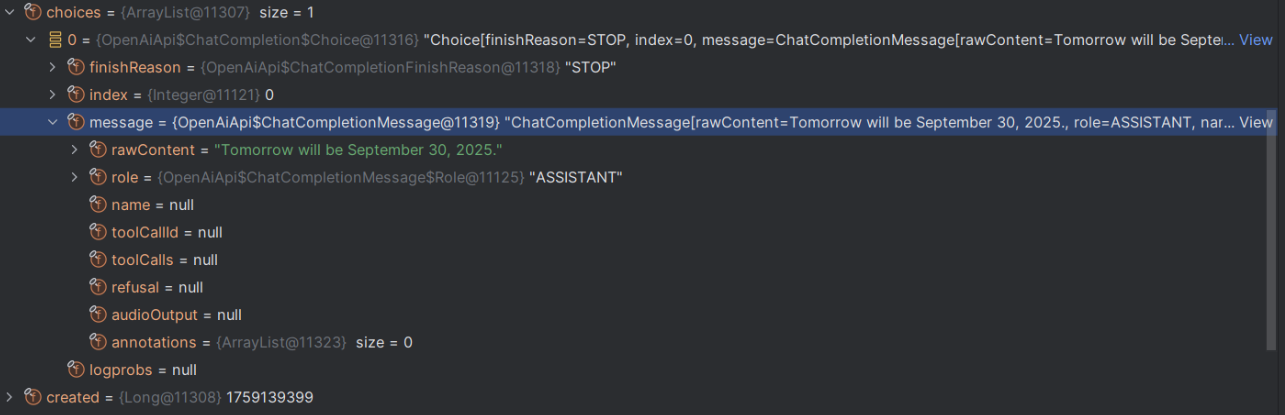
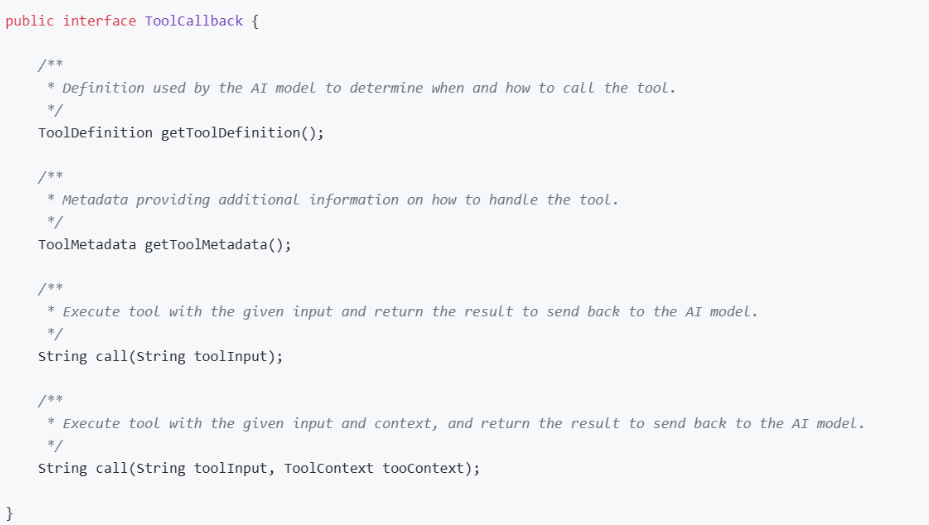

### 7.3 Tool Context
Sometimes your tool needs extra information that doesn’t come from the LLM. That’s what ToolContext is for. It lets us attach extra metadata when calling the tool, without exposing it to the AI model.

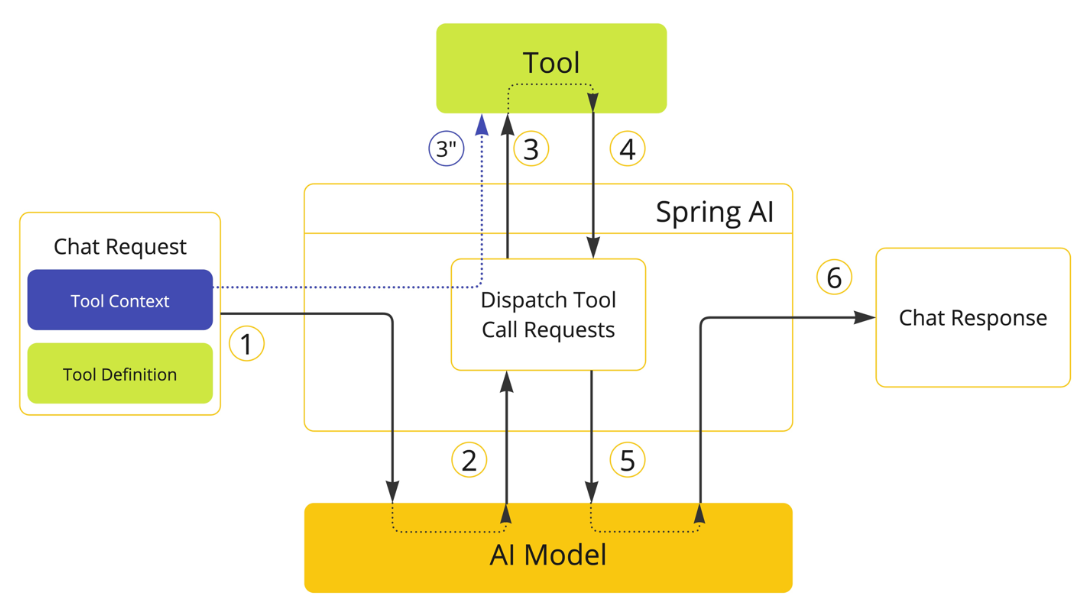
```
String response = chatClient.
        .prompt("Tell me more about the customer with ID 42")
        .tools(new CustomerTools())
        .toolContext(Map.of("tenantId", "acme"))
        .call()
        .content();
```
**None of the data provided in the ToolContext is sent to the AI model.**

### 7.3 Direct Returns
There are cases where you’d rather return the result directly to the caller instead of sending it back to the model.

- The user asks: “What’s my account balance?” → return the exact number, not a generated sentence.
- The model calls an internal API or database → you want to show that data directly, not a paraphrased version.
- The tool triggers an action (like sending an email or creating a ticket) → you only need the outcome confirmation.
- You can mark a tool to return the result directly to the caller by setting the returnDirect attribute of the @Tool annotation to true.

```
class CustomerTools {

    @Tool(description = "Retrieve customer information", returnDirect = true)
    Customer getCustomerInfo(Long id) {
        return customerRepository.findById(id);
    }

}
```

If using the programmatic approach, you can set the returnDirect attribute via the ToolMetadata interface and pass it to the MethodToolCallback.Builder.

```
ToolMetadata toolMetadata = ToolMetadata.builder()
    .returnDirect(true)
    .build();
```

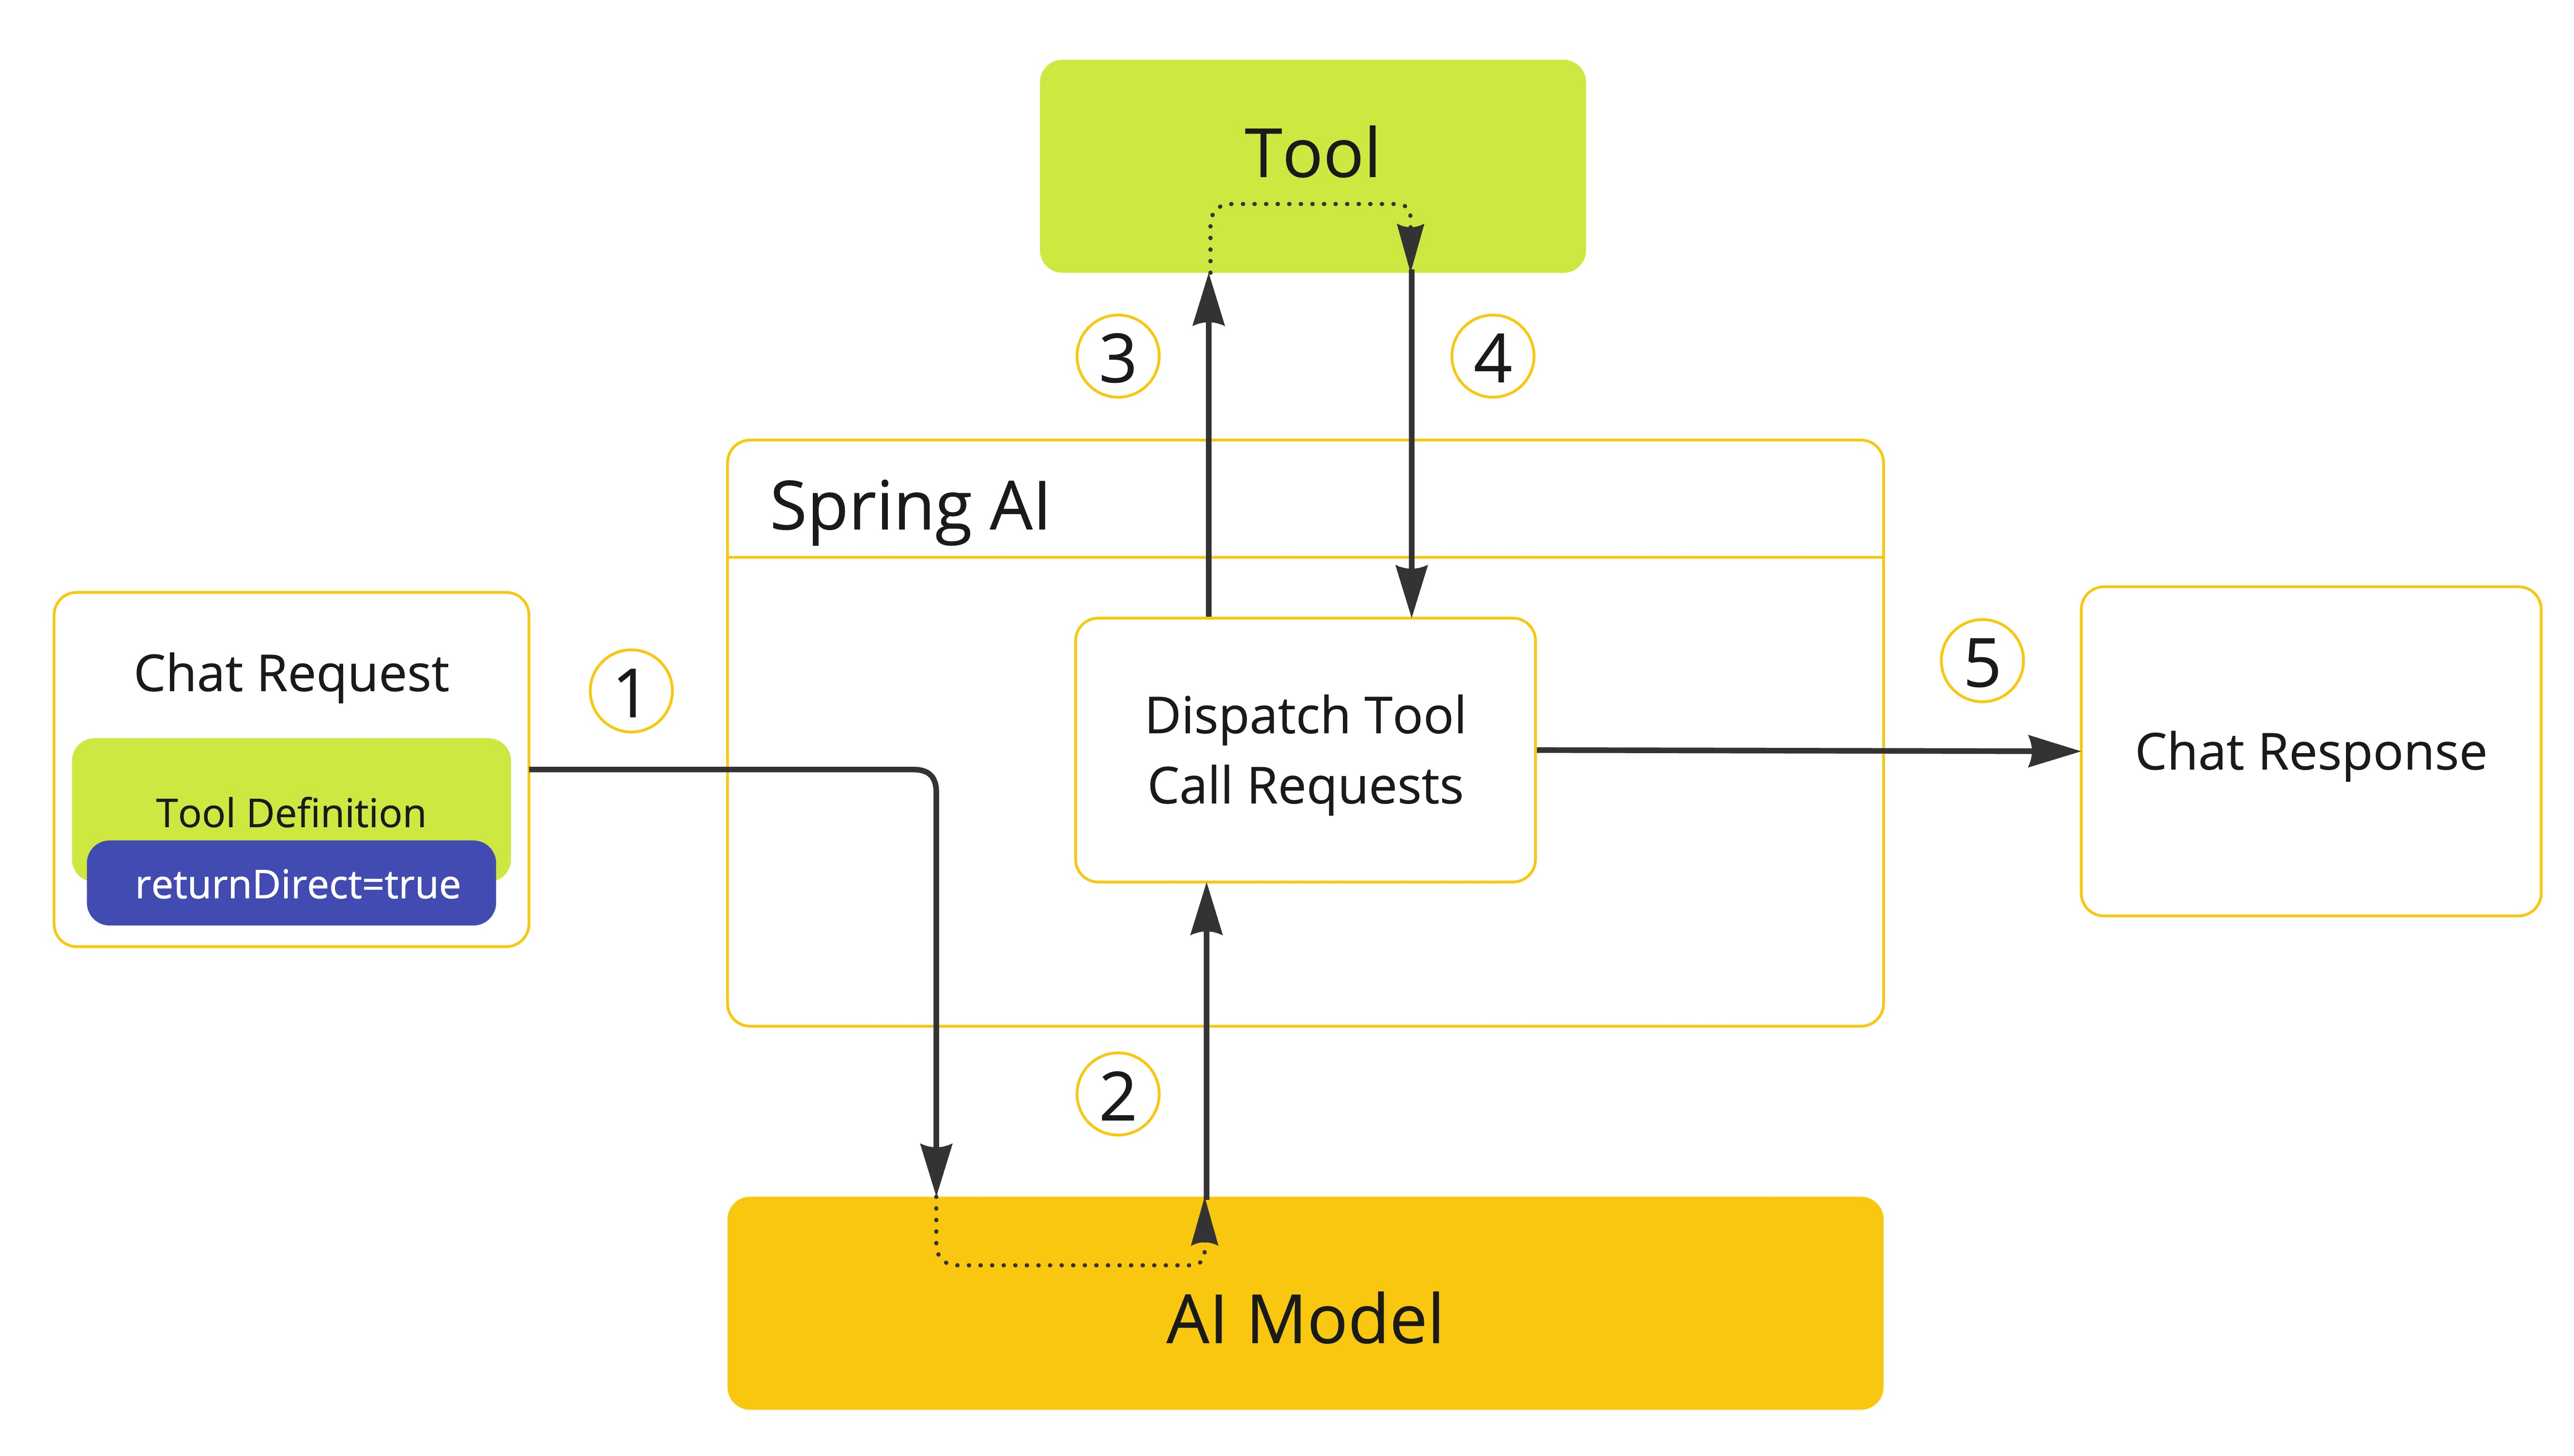

### 7.4 When a Tool Calling Fails
When a tool call fails, the exception is propagated as a ToolExecutionException which can be caught to handle the error. A ToolExecutionExceptionProcessor can be used to handle a ToolExecutionException with two outcomes:
- Producing an error message to be sent back to the AI model
- Throwing an exception to be handled by the caller.

```java
@FunctionalInterface
public interface ToolExecutionExceptionProcessor {

	/**
	 * Convert an exception thrown by a tool to a String that can be sent back to the AI
	 * model or throw an exception to be handled by the caller.
	 */
	String process(ToolExecutionException exception);

}
```

---

## 8. Advisors: Cross-Cutting Behaviours

You may think that Spring AI, with all its abstractions and simplifications, might not give you enough flexibility or fine-grained control over how your application interacts with the model.

After all, LLMs themselves are stateless — they don’t remember past interactions or maintain context across calls unless you explicitly resend it.

If you want the model to make smarter, context-aware decisions — like reusing previous information, searching for relevant data, or adjusting behavior based on current system state — you need an orchestration layer that can inject that context dynamically.

Spring AI’s ChatClient introduces a powerful concept called Advisors — a mechanism that gives you deep, customizable control over every stage of your AI interaction pipeline.
Advisors are your way to inject behavior, enforce policies, and shape the conversation flow — without breaking the simplicity of the Spring AI API.

```
Your App → Advisor 1 → Advisor 2 → Advisor N → LLM
         ← Advisor 1 ← Advisor 2 ← Advisor N ←

```

- `QuestionAnswerAdvisor` attaches RAG results from a `VectorStore`
- `MessageChatMemoryAdvisor` stores conversational history
- `SimpleLoggerAdvisor` prints final prompts, responses, tools, and token metrics

### 8.1 Execution Order

#### Critical: Lower order values execute first.

```
getOrder() = 0    // Executes FIRST  (HIGHEST_PRECEDENCE)
getOrder() = 100  // Executes LAST   (LOWEST_PRECEDENCE)
```

#### Stack Behavior
The chain works like a stack:

- Request Phase: First advisor in → Last advisor in → LLM
- Response Phase: LLM → Last advisor out → First advisor out

Example with order values:
```
Request:  Advisor(0) → Advisor(50) → Advisor(100) → LLM
Response: Advisor(0) ← Advisor(50) ← Advisor(100) ← LLM
Advisor(0) processes the request first and response last.
```

### 8.3 Let's Build An Advisor

In [17]:

import org.slf4j.Logger
import org.slf4j.LoggerFactory
import org.springframework.ai.chat.client.ChatClientResponse
import org.springframework.ai.chat.client.advisor.api.CallAdvisorChain
import org.springframework.ai.chat.client.ChatClientRequest
import org.springframework.ai.chat.client.advisor.api.CallAdvisor

class SimpleLoggerAdvisor : CallAdvisor {
    override fun getName(): String {
        return this.javaClass.getSimpleName()
    }

    override fun getOrder(): Int {
        return 0 // Execute first
    }

    override fun adviseCall(
        request: ChatClientRequest,
        chain: CallAdvisorChain
    ): ChatClientResponse {
        System.out.println("Request: " +  request)
        val response = chain.nextCall(request)
        System.out.println("Response: " +  response)
        val newContext = HashMap(request.context())
        newContext["timestamp"] = System.currentTimeMillis()
        newContext["advisor"] = "TimingAdvisor"
        return response.mutate()
            .context(newContext)
            .build()    }
    
    companion object {
        private val logger: Logger = LoggerFactory.getLogger(SimpleLoggerAdvisor::class.java)
    }
}

In [18]:
import org.springframework.ai.chat.client.ChatClient
import org.springframework.ai.chat.model.ChatModel

val chatModel = context.getBean(ChatModel::class.java)

val chatClient = ChatClient.builder(chatModel)
    .defaultAdvisors(
        org.springframework.ai.chat.client.advisor.SimpleLoggerAdvisor() // <-- our custom advisor
    )
    .build()

val response = chatClient.prompt()
    .user("Summarize Spring AI in one sentence.")
    .call()
    .content()

println(response)


Spring AI is a framework that integrates artificial intelligence capabilities into Spring applications, enabling developers to build intelligent features and services efficiently.


## References

- [Spring AI ChatClient Reference](https://docs.spring.io/spring-ai/reference/api/chatclient.html)
- [Spring AI Prompt and Message Reference](https://docs.spring.io/spring-ai/reference/api/prompt.html)
- [Anthropic: Effective Context Engineering](https://www.anthropic.com/engineering/effective-context-engineering-for-ai-agents)
- [Spring AI OpenAI Chat (Images and Audio)](https://docs.spring.io/spring-ai/reference/api/chat/openai-chat.html)
- [OpenAI Structured Outputs Guide](https://platform.openai.com/docs/guides/structured-outputs)
- [Spring AI Tools API and Function Calling](https://docs.spring.io/spring-ai/reference/api/tools.html)

## Next Steps

Continue to the next notebook: [Agentic Patterns](./agentic-patterns.ipynb) to learn about workflows, agents, and advanced orchestration patterns.